In [1]:
import pandas as pd
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import odr
# import statsmodels.api as sm

In [2]:
folder = Path('data')

## Contents
 - [Rookie Cap, Cap Maximum via Spotrac](#Salary-Cap)
   - used 2020-2023 to fit % Cap vs Draft Pick
 - [2023 Market Contracts via OTC](#Market-Data)
   - define market rate for a position / group of positions
     - % Cap = Contract APY / 2023 max Cap
   - players not in draft data were not used for analysis
     - drafted before 2011, undrafted, position mismatch
   - used player position from contract data to adjust some positions in draft data
 - [Draft Data via PFR](#Draft-Data)
   - use PFR's AV and games played to define performance: **AVpG**
     - convert AVpG to percentile for each postion
   - 2011 (CBA) to 2023


### Salary Cap 
 - Salary Cap vs Year | [spotrac.com/nfl/cba/](https://www.spotrac.com/nfl/cba/)
   - 1994 to 2023, with projected cap for 2025
   - 2010 did not have a salary cap, rookie cap rules 2011 and after
 - Cap hit vs Draft Pick | [spotrac.com/nfl/draft/`YEAR`/](https://www.spotrac.com/nfl/draft/2023/)
   - 2020 to 2023, converted cap hit to cap percentage using cap history data
   - defined `% cap vs draft pick`

In [3]:
# Max Cap vs Year
cap_history = pd.read_html('https://www.spotrac.com/nfl/cba/')[0]
cap_history = cap_history.iloc[:,0:2]
cap_history.rename(columns={'Cap Maximum':'Cap'}, inplace=True)

cap_history.loc[:,'Cap'] = cap_history['Cap'].str.replace('$','').str.replace(',','')
cap_history.loc[:,'Cap'] = cap_history['Cap'].str.replace('Uncapped','0')
cap_history['Cap'] = cap_history['Cap'].astype(int)

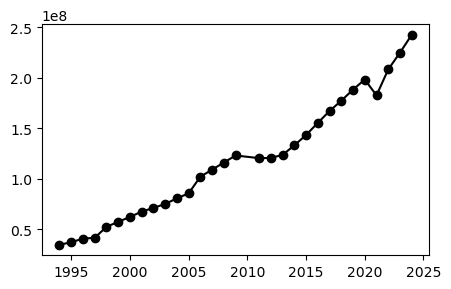

In [5]:
# no cap in 2010
plt.figure(figsize=(5,3))
plt.plot(cap_history[cap_history.Year!=2010].Year,
         cap_history[cap_history.Year!=2010].Cap,
         'ko-')
plt.show()

In [6]:
cap_history.to_csv(Path(folder,'salary_cap_history.csv'))
max_cap = cap_history[cap_history.Year==2023].Cap.values[0]

In [7]:
class DraftCapTables:
    def __init__(self, year):
        self.year = year
        self.table = None
    
    def data_import(self):
        URL = f'https://www.spotrac.com/nfl/draft/{self.year}/'
        ts = pd.read_html(URL)
        df = pd.DataFrame()
        
        # gather only round tables, rename YEAR cap to cap
        # only considering draft year cap hit
        for val in ts:
            if val.shape[0]>15:
                df = pd.concat([df, val])
        df.reset_index(inplace=True,drop=True)
        df = df[['Pick', 'Player', 'Pos', f'{self.year} Cap']]
        df.rename(columns={f'{self.year} Cap':'Cap'}, inplace=True)
        
        # convert dollars to sense
        df.loc[:,'Cap'] = df['Cap'].str.replace('$','').str.replace(',','')
        df.loc[:,'Cap'] = df['Cap'].str.replace('-','0')
        df['Cap'] = df['Cap'].astype(int)
                
        # Move Comp designation out of Pick
        df.loc[:,'Pick2'] = df['Pick'] # unsure why needed
        df.loc[:,'Comp'] = df.Pick.str.find(' (Comp)') > 0
        df.loc[:,'Pick'] = df.Pick.str.replace(' (Comp)','')
        df.loc[:,'Pick'] = df.Pick.fillna(df.Pick2)
        df.drop(columns='Pick2', inplace=True)
        
        df.loc[:,'Year'] = self.year
        self.table = df
        
    def save(self, folder):
        if type(self.table) == type(None):
            return
        p = Path(folder, f'draft-cap_{self.year}.csv')
        self.table.to_csv(p)

In [8]:
df = pd.DataFrame()
for year in range(2020,2024):
    t = DraftCapTables(year)
    t.data_import()
    df = pd.concat([df, t.table])
    df.reset_index(inplace=True,drop=True)
    # t.save(folder)
    print(year, 'completed')

2020 completed
2021 completed
2022 completed
2023 completed


In [9]:
for year in df.Year.unique():
    ind = df[df.Year==year].index
    year_max = cap_history[cap_history.Year==year].Cap.values[0]
    df.loc[ind,'CapPerc'] = 100*df.loc[ind,'Cap'] / year_max

In [10]:
draft_cap = df.copy()
draft_cap.dtypes

Pick        object
Player      object
Pos         object
Cap          int32
Comp          bool
Year         int64
CapPerc    float64
dtype: object

In [11]:
draft_cap['Pick'] = draft_cap['Pick'].astype(str)
draft_cap = draft_cap[~draft_cap.Pick.str.endswith(')')]
draft_cap = draft_cap[draft_cap.Pick!='-']
draft_cap['Pick'] = draft_cap['Pick'].astype(int)

In [12]:
draft_cap.dtypes

Pick         int32
Player      object
Pos         object
Cap          int32
Comp          bool
Year         int64
CapPerc    float64
dtype: object

In [13]:
# pick bounds, order of polynomial fit

curve_fits = {
    'Round 1': (1,32,4),
    'Round 2': (33,64,3),
    'Rounds 3-5': (65,173,1),
    'Rounds 6-7': (174,draft_cap.Pick.max(),1),
}

rd_ticks = [1,33,65, 100, 137, 174, 214, 256]

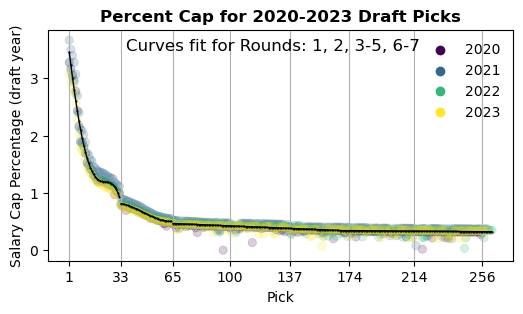

In [14]:
plt.figure(figsize=(6,3), dpi=100)
sns.scatterplot(draft_cap, x='Pick', y='CapPerc', hue='Year',
                edgecolor='face', alpha=0.2, palette='viridis',)

cap_table = pd.DataFrame(index=np.linspace(1,draft_cap.Pick.max(), draft_cap.Pick.max()))

for key,val in curve_fits.items():
    # curve fit specified range (val[0]-val[1]) and degree: val[2]
    data = odr.Data(draft_cap[(draft_cap.Pick>=val[0]) & (draft_cap.Pick<=val[1])].Pick,
                    draft_cap[(draft_cap.Pick>=val[0]) & (draft_cap.Pick<=val[1])].CapPerc)
    x = np.linspace(val[0],val[1], val[1]-val[0]+1)    
    poly_model = odr.polynomial(val[2]) 
    odr_obj = odr.ODR(data, poly_model)
    output = odr_obj.run()  # running ODR fittinh
    poly = np.poly1d(output.beta[::-1])
    poly_y = poly(x)
    plt.plot(x,poly_y,'k.-', linewidth=1, markersize=1)
    
    cap_table.loc[x,'Perc'] = poly_y

plt.xticks(ticks = rd_ticks)
plt.grid(axis='x')
plt.title('Percent Cap for 2020-2023 Draft Picks', fontweight='bold')
plt.suptitle('Curves fit for Rounds: 1, 2, 3-5, 6-7', y=0.85)
plt.ylabel('Salary Cap Percentage (draft year)')
plt.legend(frameon=False)
plt.savefig(Path(folder, 'draft cap table.png'))
plt.show()

In [62]:
cap_table.index = cap_table.index.astype(int)
cap_table.to_csv(Path(folder, 'pick_cap_percentage.csv'))

### Market Data
 - all 2023 contracts | [overthecap.com/contracts](https://overthecap.com/contracts)  *link for current year*
   - used APY (average per year) and 2023 max cap to define `% cap`

In [ ]:
# cap_history = pd.read_csv(Path(folder, 'salary_cap_history.csv'), index_col=0)
# max_cap = cap_history[cap_history.Year==2023].Cap.values[0]
# del cap_history
print(max_cap)

In [65]:
data = pd.read_html('https://overthecap.com/contracts')[0]

In [66]:
data.rename(columns={'Pos.':'Pos', 'Team':'Tm', 'Avg. Guarantee/Year':'AGY',}, inplace=True)

for col in ['Total Value', 'APY', 'Total Guaranteed', 'AGY']:
    data.loc[:,col] = data[col].str.replace('$','').str.replace(',','')
    data[col] = data[col].astype(int)
    
for col in ['% Guaranteed']:
    data.loc[:,col] = data[col].str.replace('%','')
    data[col] = data[col].astype(float)
    
data.loc[:,'APY_Cap'] = 100*round(data.APY/max_cap,5)

In [74]:
data.to_csv(Path(folder, 'vet_contracts.csv'))

In [67]:
data.head()

,Player,Pos,Tm,Total Value,APY,Total Guaranteed,AGY,% Guaranteed,APY_Cap
0,Joe Burrow,QB,Bengals,275000000,55000000,146510000,29302000,53.3,24.466
1,Justin Herbert,QB,Chargers,262500000,52500000,133738375,26747675,50.9,23.354
2,Lamar Jackson,QB,Ravens,260000000,52000000,135000000,27000000,51.9,23.132
3,Jalen Hurts,QB,Eagles,255000000,51000000,110000000,22000000,43.1,22.687
4,Russell Wilson,QB,Broncos,245000000,49000000,124000000,24800000,50.6,21.797


<Axes: xlabel='APY_Cap', ylabel='Pos'>

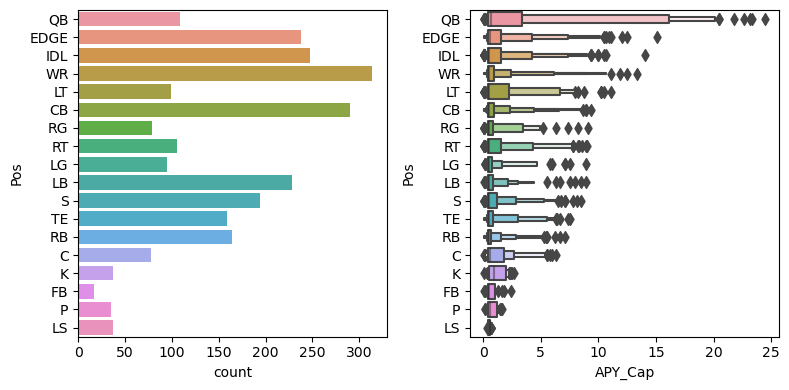

In [73]:
plt.figure(figsize=(8,4), layout='tight')
plt.subplot(121)
sns.countplot(y = data.Pos)
plt.subplot(122)
sns.boxenplot(x = data.APY_Cap, y=data.Pos)

### Draft Data
  - draft picks with player career stats | [pro-football-reference.com/years/`YEAR`/draft.htm](https://www.pro-football-reference.com/years/2023/draft.htm)
    - will use [Approximate Value](https://www.pro-football-reference.com/about/approximate_value.htm) / Games played to define performance

In [75]:
class DraftTable:
    def __init__(self, year):
        self.year = year
        self.table = None
    
    def data_import(self):
        URL = f"https://www.pro-football-reference.com/years/{self.year}/draft.htm"
        data = pd.read_html(URL)[0]
        
        # clean column names, drop extras
        rename = []
        for c_name in data.columns:
            if c_name[0].startswith('Unnamed:'):
                rename.append(c_name[1])
            else:
                rename.append(f"{c_name[0]}_{c_name[1]}")
        data.columns = rename
        data.rename(columns={'St':'Yrs_Starter', 'Solo':'Tackles_Solo', 'College/Univ':'Uni'}, inplace=True)
        data.drop(data.columns[-1], inplace=True, axis=1)
        data.fillna(0, inplace=True)
        data = data[data.Pos!='Pos']
        data.loc[:,'draft_year'] = self.year
        self.table = data
        
    def save(self, folder):
        if type(self.table) == type(None):
            return
        p = Path(folder, f'draft_{self.year}.csv')
        self.table.to_csv(p)
    
    def dtypes_opt(self):
        if type(self.table) == type(None):
            return
        # ignore warning for this
        pd.options.mode.chained_assignment = None
        
        # object --> string
        str_cols = ['Tm','Player','Pos','Uni']
        self.table[str_cols] = self.table[str_cols].astype('string')
        # sack --> float
        self.table['Sk'] = self.table['Sk'].astype(float)
        # rest --> int
        int_cols = self.table.columns[~self.table.columns.isin(str_cols + ['Sk'])]
        self.table[int_cols] = self.table[int_cols].astype(int)

        # restore warning
        pd.options.mode.chained_assignment = 'warn'

In [76]:
# folder to store imported data
# folder = Path('data')
# combine all data to one table
df = pd.DataFrame()

for year in range(2011,2024):
    t = DraftTable(year)
    t.data_import()
    df = pd.concat([df, t.table])
    # save each year separately
    # t.save(folder)
    print(year, 'completed')

2011 completed
2012 completed
2013 completed
2014 completed
2015 completed
2016 completed
2017 completed
2018 completed
2019 completed
2020 completed
2021 completed
2022 completed
2023 completed


In [77]:
# clean combined table (2011-2023 drafts)
df.reset_index(drop=True,inplace=True)

# ignore warning for this
pd.options.mode.chained_assignment = None

# object --> string
str_cols = ['Tm','Player','Pos','Uni']
df[str_cols] = df[str_cols].astype('string')
# sack --> float
df['Sk'] = df['Sk'].astype(float)
# rest --> int
int_cols = df.columns[~df.columns.isin(str_cols + ['Sk'])]
df[int_cols] = df[int_cols].astype(int)

# restore warning
pd.options.mode.chained_assignment = 'warn'

In [82]:
df.to_csv(Path(folder, f'draft_2011-2023.csv'))

In [79]:
df.columns

Index(['Rnd', 'Pick', 'Tm', 'Player', 'Pos', 'Age', 'To', 'Misc_AP1',
       'Misc_PB', 'Yrs_Starter', 'Approx Val_wAV', 'Approx Val_DrAV', 'G',
       'Passing_Cmp', 'Passing_Att', 'Passing_Yds', 'Passing_TD',
       'Passing_Int', 'Rushing_Att', 'Rushing_Yds', 'Rushing_TD',
       'Receiving_Rec', 'Receiving_Yds', 'Receiving_TD', 'Tackles_Solo', 'Int',
       'Sk', 'Uni', 'draft_year'],
      dtype='object')

In [78]:
df.sample(3)

,Rnd,Pick,Tm,Player,Pos,Age,To,Misc_AP1,Misc_PB,Yrs_Starter,...,Rushing_Yds,Rushing_TD,Receiving_Rec,Receiving_Yds,Receiving_TD,Tackles_Solo,Int,Sk,Uni,draft_year
2578,2,35,DEN,Javonte Williams,RB,21,2023,0,0,0,...,1881,7,106,620,5,1,0,0.0,North Carolina,2021
3271,6,207,GNB,Anders Carlson,K,25,2023,0,0,0,...,0,0,0,0,0,1,0,0.0,Auburn,2023
1355,3,83,NYJ,Jordan Jenkins,OLB,22,2021,0,0,5,...,0,0,0,0,0,124,0,25.0,Georgia,2016


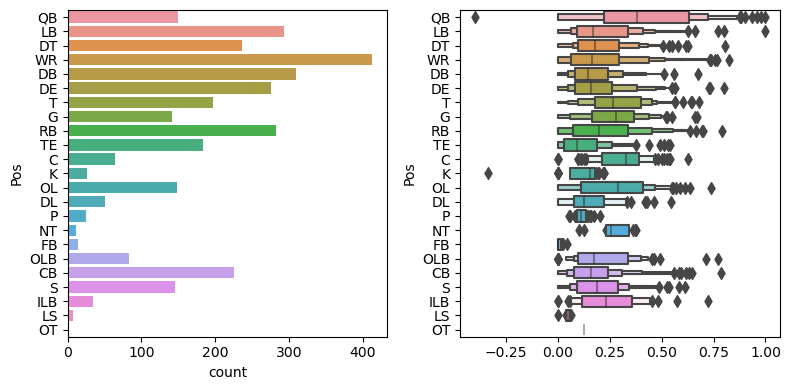

In [81]:
plt.figure(figsize=(8,4), layout='tight')
plt.subplot(121)
sns.countplot(y = df.Pos)
plt.subplot(122)
sns.boxenplot(x = df['Approx Val_wAV']/df['G'], y=df.Pos)
plt.show()